# Real-time music auto-tagging
In this tutorial, we use Essentia's TensorFlow integration to perform auto-tagging in real-time.
Additionally, this serves as an example of TensorFlow inference in streaming mode and can be easily adapted to work offline.


## Setup
To install Essentia with TensorFlow support, refer to the [Setup](https://essentia.upf.edu/tutorial_tensorflow_auto-tagging_classification_embeddings.html#setup) section of our previous *Music auto-tagging, classification, and embedding extraction* tutorial for instructions.

Additionally, we rely on the `pysoundcard` package to capture the audio loopback of the system and feed Essentia in real-time. This way we can easily test our models with any music coming from our local player or browser.

In [1]:
!pip -q install pysoundcard

Let's download `MusiCNN`,  one of our auto-tagging models. This and more models are available from the [Essentia models](https://essentia.upf.edu/models.html)' site.

In [2]:
!wget -q https://essentia.upf.edu/models/autotagging/msd/msd-musicnn-1.pb
!wget -q https://essentia.upf.edu/models/autotagging/msd/msd-musicnn-1.json

Then we import the required packages and Essentia algorithms.
In this case, we use the TensorFlow functionalities in streaming mode.


In [11]:
import json

from essentia.streaming import (
    VectorInput,
    FrameCutter,
    TensorflowInputMusiCNN,
    VectorRealToTensor,
    TensorToPool,
    TensorflowPredict,
    PoolToTensor,
    TensorToVectorReal
)
from essentia import Pool, run, reset
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import soundcard as sc

%matplotlib nbagg

Define the analysis parameters.
To make this demo work in real-time, we tweaked some of the analysis parameters of `MusiCNN`.
While it was trained on patches of size 187 (\~3 seconds) we set `patch_size` to 64 (\~1 second) to increase the prediction rate.
You can experiment with the `patch_size` and `display_size` parameters to modify the prediction rate to your taste.

In [4]:
with open('msd-musicnn-1.json', 'r') as json_file:
    metadata = json.load(json_file)

model_file = 'msd-musicnn-1.pb'
input_layer = metadata['schema']['inputs'][0]['name']
output_layer = metadata['schema']['outputs'][0]['name']
classes = metadata['classes']
n_classes = len(classes)

# Analysis parameters.
sample_rate = 16000
frame_size = 512 
hop_size = 256
n_bands = 96
patch_size = 64
display_size = 10

buffer_size = patch_size * hop_size

Instantiate the algorithms. With this, we create a network similar to the one used inside `TensorflowPredictMusiCNN`, the wrapper algorithm presented in the previous tutorial. However, by instantiating the algorithms separately we gain additional control required for real-time usage.

In [5]:
buffer = np.zeros(buffer_size, dtype='float32')
vimp = VectorInput(buffer)
fc = FrameCutter(frameSize=frame_size, hopSize=hop_size)
tim = TensorflowInputMusiCNN()
vtt = VectorRealToTensor(shape=[1, 1, patch_size, n_bands],
                         lastPatchMode='discard')
ttp = TensorToPool(namespace=input_layer)
tfp = TensorflowPredict(graphFilename=model_file,
                        inputs=[input_layer],
                        outputs=[output_layer])
ptt = PoolToTensor(namespace=output_layer)
ttv = TensorToVectorReal()
pool = Pool()

Connect the algorithms. We also store the mel-spectrograms in the `Pool` for visualization purposes.

In [6]:
vimp.data   >> fc.signal
fc.frame    >> tim.frame
tim.bands   >> vtt.frame
tim.bands   >> (pool, 'melbands')
vtt.tensor  >> ttp.tensor
ttp.pool    >> tfp.poolIn
tfp.poolOut >> ptt.pool
ptt.tensor  >> ttv.tensor
ttv.frame   >> (pool, output_layer)

Create a callback function that will be called every time the audio buffer is ready to process.

In [7]:
def callback(data):
    buffer[:] = data.flatten()

    # Generate predictions.
    reset(vimp)
    run(vimp)

    # Update the mel-spectrograms and activations buffers.
    mel_buffer[:] = np.roll(mel_buffer, -patch_size)
    mel_buffer[:, -patch_size:] = pool['melbands'][-patch_size:, :].T
    img_mel.set_data(mel_buffer)
    
    act_buffer[:] = np.roll(act_buffer, -1)
    act_buffer[:, -1] = softmax(20 * pool[output_layer][-1, :].T)
    img_act.set_data(act_buffer)

    f.canvas.draw()

Initialize the plots and start processing the loopback stream.

<IPython.core.display.Javascript object>


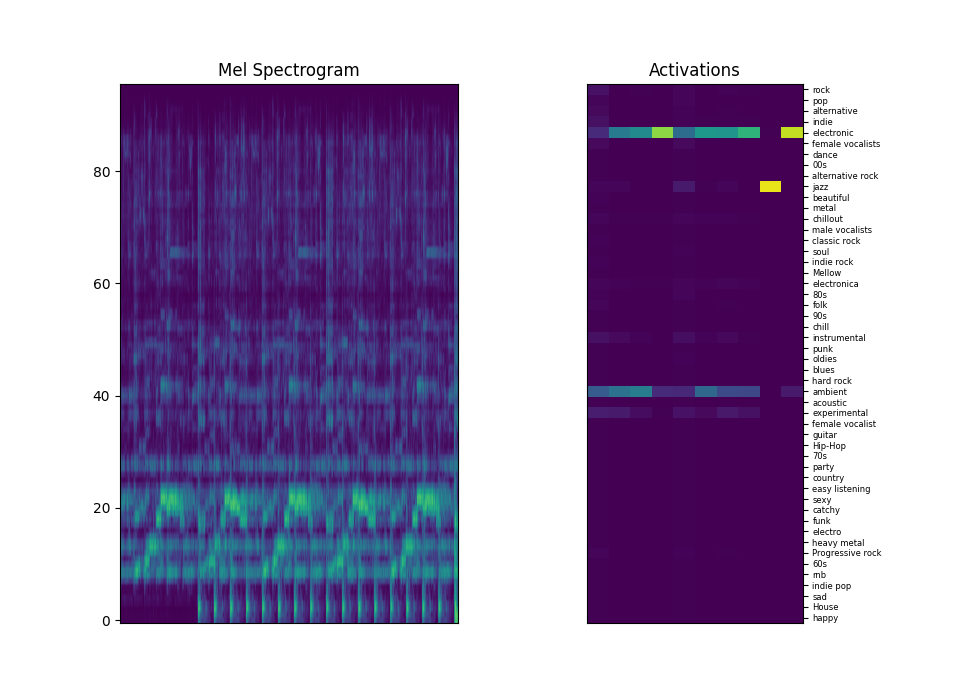

In [10]:
mel_buffer = np.zeros([n_bands, patch_size * display_size])
act_buffer = np.zeros([n_classes, display_size])

pool.clear()

f, ax = plt.subplots(1, 2, figsize=[9.6, 7])
f.canvas.draw()

ax[0].set_title('Mel Spectrogram')
img_mel = ax[0].imshow(mel_buffer, aspect='auto',
                       origin='lower', vmin=0, vmax=6)
ax[0].set_xticks([])

ax[1].set_title('Activations')
img_act = ax[1].matshow(act_buffer, aspect='0.5', vmin=0, vmax=1)
ax[1].set_xticks([])
ax[1].yaxis.set_ticks_position('right')
plt.yticks(np.arange(n_classes), classes, fontsize=6)

# Capture and process the speakers loopback.
with sc.all_microphones(include_loopback=True)[0].recorder(samplerate=sample_rate) as mic:
    while True:
        callback(mic.record(numframes=buffer_size).mean(axis=1))